In [1]:
#import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [2]:
deeplabv3plus_srcdir="./src"
sys.path.append(deeplabv3plus_srcdir)

In [3]:
gpu_options = tf.compat.v1.GPUOptions(visible_device_list="1", allow_growth=True)
config = tf.compat.v1.ConfigProto(gpu_options = gpu_options)
tf.compat.v1.enable_eager_execution(config=config)

In [4]:
from model import deeplab_v3plus_transfer_os16
#from image_utils import make_x_from_image_paths,make_y_from_image_paths,convert_y_to_image_array
from data_gen import DataGenerator
from metrics import IoU

In [5]:
import importlib
importlib.reload(sys.modules['model'])

<module 'model' from './src/model.py'>

In [6]:
out_dir = "xception_transfer_os16"
os.makedirs(out_dir, exist_ok=True)

In [7]:
n_categories = 21
image_size = (512,512)

In [8]:
seg_img_dir = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/SegmentationClass"
img_dir = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/JPEGImages"
train_set_path = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt"
valid_set_path = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"

with open(train_set_path) as f:
    train_img_names = f.read().split("\n")[:-1]
with open(valid_set_path) as f:
    valid_img_names = f.read().split("\n")[:-1]

img_paths = np.array([os.path.join(img_dir,train_img_names[i]) + ".jpg" for i in range(len(train_img_names))])
seg_img_paths = np.array([os.path.join(seg_img_dir,train_img_names[i]) + ".png" for i in range(len(train_img_names))])

valid_x_paths = np.array([os.path.join(img_dir,valid_img_names[i]) + ".jpg" for i in range(len(valid_img_names))])
valid_y_paths = np.array([os.path.join(seg_img_dir,valid_img_names[i]) + ".png" for i in range(len(valid_img_names))])

In [9]:
batch_size=16
n_epochs=300

In [10]:
encoder = keras.applications.Xception(input_shape=(512,512,3), weights="imagenet", include_top=False)
preprocess = keras.applications.xception.preprocess_input
layer_name_to_decoder = "block3_sepconv2_bn"
encoder_end_layer_name = "block13_sepconv2_bn"
model = deeplab_v3plus_transfer_os16(n_categories, encoder, layer_name_to_decoder, encoder_end_layer_name)

W1129 14:59:16.113214 140735519411408 module_wrapper.py:139] From ./src/model.py:207: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



in decoder, layer from encoder is resized from (?, 127, 127, 256) to (?, 128, 128, 256)


In [11]:
train_data_gen = DataGenerator(n_categories, image_size, batch_size, img_paths    , seg_img_paths, preprocess, augmentation=True , shuffle=True)
valid_data_gen = DataGenerator(n_categories, image_size, batch_size, valid_x_paths, valid_y_paths, preprocess, augmentation=False, shuffle=False)

In [12]:
#model.summary(line_length=150)

In [13]:
loss_function = tf.keras.losses.categorical_crossentropy
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss=loss_function, metrics=[IoU])

In [18]:
filepath = os.path.join(out_dir,'{epoch:06d}.h5')
cp_cb = keras.callbacks.ModelCheckpoint(filepath, 
                                        monitor='val_IoU', 
                                        verbose=1, 
                                        save_best_only=True, 
                                        save_weights_only=False, 
                                        mode='max')

In [19]:
#hist = model.fit_generator(data_gen, validation_data=(valid_x, valid_y), epochs=par.n_epochs, steps_per_epoch=par.n_batch, callbacks=[cp_cb])
hist = model.fit_generator(train_data_gen,
                           epochs=n_epochs,
                           steps_per_epoch=len(train_data_gen),
                           validation_data=valid_data_gen,
                           validation_steps=len(valid_data_gen),
                           #shuffle = False,
                           workers=8,
                           use_multiprocessing=True,
                           callbacks=[cp_cb])
#hist = model.fit_generator(data_gen, epochs=par.n_epochs, steps_per_epoch=par.n_batch, workers=8, use_multiprocessing=True)

Epoch 1/300
91/92 [============================>.] - ETA: 0s - loss: 2.7181 - IoU: 0.0000e+00
Epoch 00001: val_IoU improved from -inf to 0.00000, saving model to xception_transfer_os16/000001.h5
92/92 [==============================] - 206s 2s/step - loss: 2.1839 - IoU: 0.0232 - val_loss: 2.7181 - val_IoU: 0.0000e+00
Epoch 2/300
91/92 [============================>.] - ETA: 0s - loss: 2.3681 - IoU: 0.0000e+00
Epoch 00002: val_IoU did not improve from 0.00000
92/92 [==============================] - 180s 2s/step - loss: 1.9434 - IoU: 0.0473 - val_loss: 2.3681 - val_IoU: 0.0000e+00
Epoch 3/300
91/92 [============================>.] - ETA: 0s - loss: 2.0127 - IoU: 7.3360e-08
Epoch 00003: val_IoU improved from 0.00000 to 0.00000, saving model to xception_transfer_os16/000003.h5
92/92 [==============================] - 179s 2s/step - loss: 1.7888 - IoU: 0.0565 - val_loss: 2.0127 - val_IoU: 7.3360e-08
Epoch 4/300
91/92 [============================>.] - ETA: 0s - loss: 1.6069 - IoU: 0.0080
E

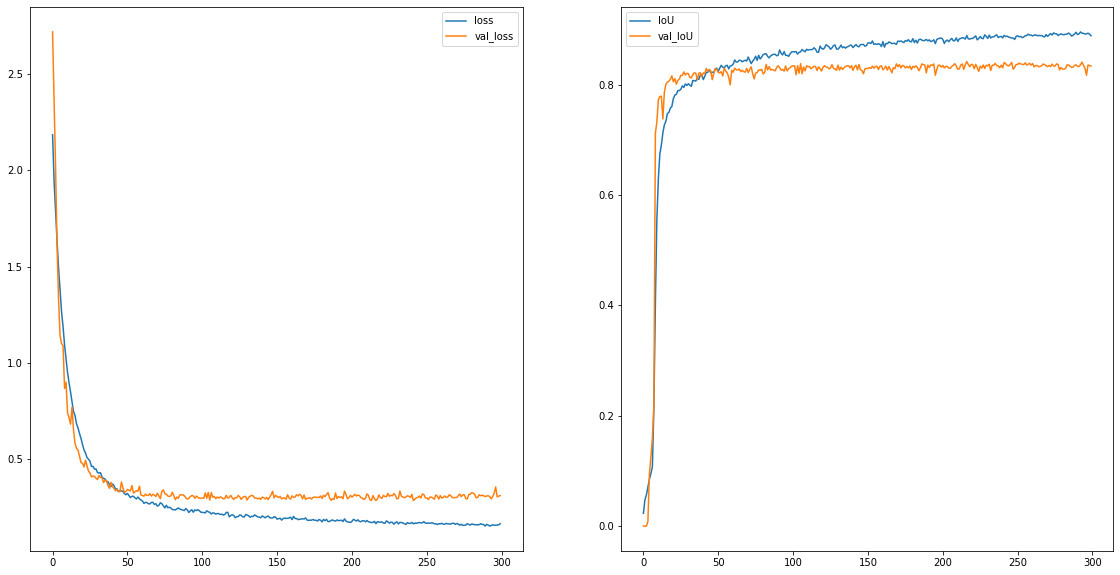

In [20]:
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(hist.history["IoU"], label="IoU")
plt.plot(hist.history["val_IoU"], label="val_IoU")
plt.legend()
plt.savefig(os.path.join(out_dir,'losscurve.png'))

In [21]:
model.save(os.path.join(out_dir,'final_epoch.h5'))

In [22]:
for key in sorted(hist.history.keys()):
    np.savetxt(os.path.join(out_dir,key+'.txt'),np.array(hist.history[key]))
